In [10]:
# General stuff
import os
import re
import time
import warnings
import math
import sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
from IPython.core.debugger import Tracer
from scipy.optimize import curve_fit

# sklearn stuff
from sklearn.utils import resample

# personal functions
from importlib import reload
import fsutils as fs
reload(fs)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Load local version of nilearn
if os.path.exists('/data1/vbeliveau/'):
    sys.path.append('/data1/vbeliveau/nilearn')
    import mynilearn.decomposition as dcm 
    reload(dcm)
elif os.path.exists('C:/Users/vbeliveau/'):
    sys.path.append('C:/Users/vbeliveau/Downloads/nilearn-master')
    import mynilearn.decomposition as dcm
    reload(dcm)
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
fs.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
fs.assert_dir(BPnd_data)
MFA_data=opj(cluster_data,'MFA')
MFA_preproc=opj(MFA_data,'preproc')
fs.assert_dir(MFA_data)
fs.assert_dir(MFA_preproc)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [40]:
# Run levelset on mean BPnd maps

tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

data=np.empty(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        # Load data
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')        
        data=np.mean(fs.load_surf_data(fname,mask=fmask),axis=1)
        
        # Load neighborhood structure
        fneigh=opj(surf_data,'neigh.cortex.'+targ+'.'+hemi+'.list')
        neigh,_=fs.load_surf_neighborhood(fneigh)
        
        # Perform levelset clustering
        clust=fs.surf_levelset(data,neigh)        
        dest=opj(cluster_data,'levelset','test')
        fs.assert_dir(dest)
        fname=opj(dest,tracer+'.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
        fs.save_surf_data(clust,fname,mask=fmask)
        
        # Perform levelset two-sided clustering
        clust=fs.surf_levelset_two_sided(data,neigh)
        dest=opj(cluster_data,'levelset','test.two-sided')
        fs.assert_dir(dest)
        fname=opj(dest,tracer+'.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
        fs.save_surf_data(clust,fname,mask=fmask)

In [31]:
# Bootstrap levelsets borders

tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh']
targ='fsaverage6'
sm='10'
maxiter=1000

dest=opj(cluster_data,'levelset','test.two-sided.prob')
fs.assert_dir(dest)

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        # Load data
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')        
        data=fs.load_surf_data(fname,mask=fmask)
        N=data.shape[1]
        
        # Load neighborhood structure
        fneigh=opj(surf_data,'neigh.cortex.'+targ+'.'+hemi+'.list')
        neigh,_=fs.load_surf_neighborhood(fneigh)
        
        clust_prob=np.zeros(data.shape[0])
        for ni in np.arange(0,maxiter):        
            # Perform levelset two-sided clustering
            mdata=np.mean(data[:,resample(np.arange(0,N))],axis=1)
            clust=fs.surf_levelset_two_sided(mdata,neigh)
            clust_prob+=clust==-1        
        clust_prob=clust_prob/maxiter
            
        fname=opj(dest,tracer+'.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
        fs.save_surf_data(clust_prob,fname,mask=fmask)

/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/nibabel/spatialimages.py:411: UserWarning: Using large vector Freesurfer hack; header will not be compatible with SPM or FSL
  hdr.set_data_shape(shape)


cumi, lh hemi


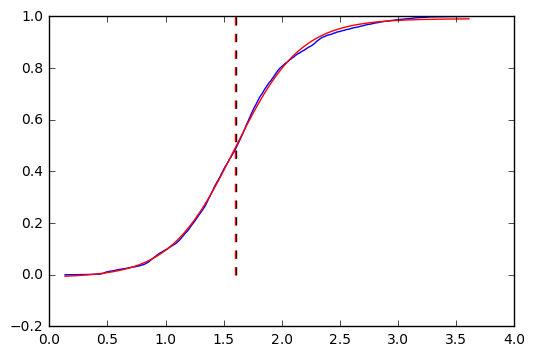

dasb, lh hemi


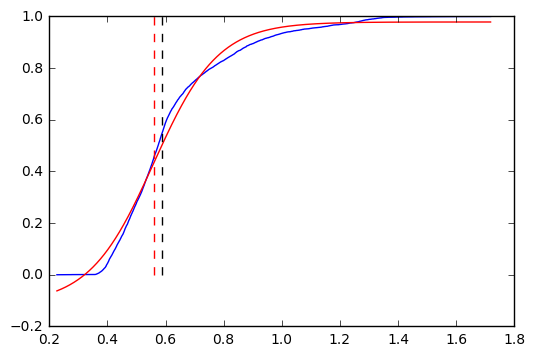

sb, lh hemi


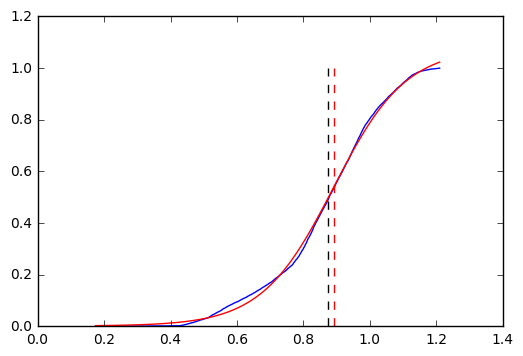

az, lh hemi


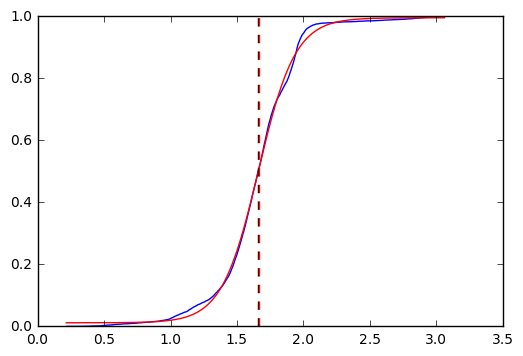

C36, lh hemi


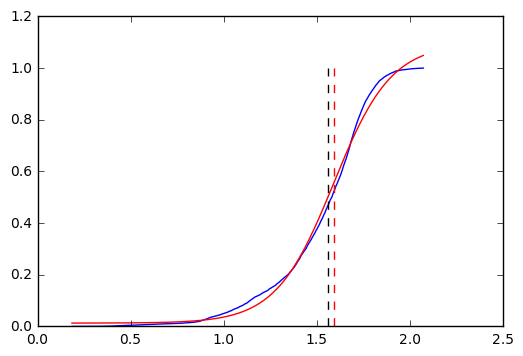

In [100]:
tracers=['cumi','dasb','sb','az','C36']
# tracers=['C36']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

def sigmoid(x, x0, k, a, c):
    y = a / (1 + np.exp(-k*(x-x0))) + c
    return y

def inv_sigmoid(y,x0,k,a,c):
    return np.log(a/(y-c)-1)/-k+x0

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        print(tracer+', '+hemi+' hemi')
        
        # Load data
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')        
        data=np.mean(fs.load_surf_data(fname,mask=fmask),axis=1)
        
        xdata=np.linspace(data.min(),data.max(),10000)
        ydata=np.array([np.sum(data<=p)/len(data) for p in xdata])

        # Fit sigmoid to data        
        p0=[np.ptp(data)/2+data.min(),1/np.ptp(data),1,0]
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0=p0)
        yh=sigmoid(xdata,*popt)
        ymax=ydata.max()
        xh2=inv_sigmoid(ymax/2,*popt)

        plt.plot(xdata,ydata,'b')
        plt.plot(xdata,yh,'r')
        plt.plot([xh2,xh2],[0,ymax],'k--')
        plt.plot([popt[0],popt[0]],[0,ymax],'r--')
        plt.show()

In [3]:
# Run levelset on mean BPnd maps

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

data=np.empty(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        # Load data
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')        
        data=np.mean(fs.load_surf_data(fname,mask=fmask),axis=1)
        
        # Load neighborhood structure
        fneigh=opj(surf_data,'neigh.cortex.'+targ+'.'+hemi+'.list')
        neigh,_=fs.load_surf_neighborhood(fneigh)
        
        # Perform levelset two-sided clustering
        clust=fs.surf_levelset_mean(data,neigh)
        dest=opj(cluster_data,'levelset','test.mean')
        fs.assert_dir(dest)
        fname=opj(dest,tracer+'.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
        fs.save_surf_data(clust,fname,mask=fmask)

In [20]:
# Bootstrap levelsets mean borders

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
hemi_type=['lh']
targ='fsaverage6'
sm='10'
maxiter=100

dest=opj(cluster_data,'levelset','test.mean')
fs.assert_dir(dest)

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        # Load data
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')        
        data=fs.load_surf_data(fname,mask=fmask)
        N=data.shape[1]
        
        # Load neighborhood structure
        fneigh=opj(surf_data,'neigh.cortex.'+targ+'.'+hemi+'.list')
        neigh,_=fs.load_surf_neighborhood(fneigh)
        
        clust=np.ndarray(maxiter,dtype=object)
        clust_prob=np.zeros(data.shape[0])
        for ni in np.arange(0,maxiter):        
            mdata=np.mean(data[:,resample(np.arange(0,N))],axis=1)
            clust[ni]=fs.surf_levelset_mean(mdata,neigh)
            clust_prob+=clust[ni]==-1  
        clust_prob=clust_prob/maxiter
        
        fname=opj(dest,tracer+'.all_iters.'+targ +'.' +hemi+'.sm' + sm) 
        np.savez(fname,clust)
        
        fname=opj(dest,tracer+'.all_iters.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
        fs.save_surf_data(np.vstack(clust).T,fname,mask=fmask)
        
        fname=opj(dest,tracer+'.prob.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
        fs.save_surf_data(clust_prob,fname,mask=fmask)

/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/nibabel/spatialimages.py:411: UserWarning: Using large vector Freesurfer hack; header will not be compatible with SPM or FSL
  hdr.set_data_shape(shape)


In [19]:
fname=opj(dest,tracer+'.all_iters.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
fs.save_surf_data(np.vstack(clust).T,fname,mask=fmask)

/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/nibabel/spatialimages.py:411: UserWarning: Using large vector Freesurfer hack; header will not be compatible with SPM or FSL
  hdr.set_data_shape(shape)
